In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

%matplotlib inline

np.random.seed(11132009)

## 1- What insights can we find by analyzing variable trends over the years?

In [15]:
data_1 = pd.read_csv("../Data/data_modified.csv")
data_1.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,explicit,key,mode,year,name,artists,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,0.995,0.514,172133,0.2560,0.00000,0.3490,-15.145,0,0.0871,79.467,0.574,0,0,1,1921,Si J'avais Su,['Alice Cocéa'],NaN,NaN,NaN
1,0.994,0.426,177733,0.2260,0.00000,0.2350,-16.126,0,0.0693,73.630,0.552,0,9,1,1921,Elle Porte Un Nom Charmant,['André Urban'],NaN,NaN,NaN
2,0.971,0.540,122000,0.0848,0.00196,0.0887,-16.055,0,0.0750,100.296,0.527,0,5,0,1921,A Ballynure Ballad,['Christopher Lynch'],NaN,NaN,NaN
3,0.950,0.607,163200,0.1380,0.00000,0.1140,-15.683,0,0.1570,113.282,0.511,0,3,1,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch'],NaN,NaN,NaN
4,0.969,0.344,120067,0.1310,0.00000,0.1450,-14.261,0,0.0616,178.212,0.257,0,10,0,1921,Just A Little Bit Of Heaven,['Christopher Lynch'],NaN,NaN,NaN


In [21]:
## DATA AGGREGATION ##

# CONTINUOUS VARIABLES #

cont_features_1 = ["acousticness", 
                   "danceability", 
                   "duration_ms", 
                   "energy", 
                   "instrumentalness", 
                   "liveness", 
                   "loudness", 
                   "popularity", 
                   "speechiness", 
                   "tempo", 
                   "valence"]
data_agg_cols_1 = ["year"] + cont_features_1
data_agg_1 = pd.DataFrame(columns = data_agg_cols_1)

# CATEGORICAL VARIABLES #

#Kyes
key_cols_1 = ["year", "key", "number", "percentage"]
key_distro_1 = pd.DataFrame(columns = key_cols_1)

#Mode
mode_cols_1 = ["year", "mode", "number", "percentage"]
mode_distro_1 = pd.DataFrame(columns = mode_cols_1)

#Explicit
explicit_cols_1 = ["year", "explicit", "number", "percentage"]
explicit_distro_1 = pd.DataFrame(columns = explicit_cols_1)

In [22]:
# Loop through each year
for i in range (1921, 2021):
    # Create a temporary dataframe for the year
    inYr = data_1["year"] == i
    yrDF = data_1.loc[inYr]
    
    ### CONTINUOUS VARIABLES ###
    
    data_agg_1 = data_agg_1.append(pd.DataFrame({"year" : [i],
                                                 "acousticness": yrDF["acousticness"].mean(), 
                                                 "danceability": yrDF["danceability"].mean(), 
                                                 "duration_ms": yrDF["duration_ms"].mean(), 
                                                 "energy": yrDF["energy"].mean(), 
                                                 "instrumentalness": yrDF["instrumentalness"].mean(), 
                                                 "liveness": yrDF["liveness"].mean(), 
                                                 "loudness": yrDF["loudness"].mean(), 
                                                 "popularity": yrDF["popularity"].mean(), 
                                                 "speechiness": yrDF["speechiness"].mean(), 
                                                 "tempo": yrDF["tempo"].mean(), 
                                                 "valence": yrDF["valence"].mean()}))
    
    #### KYES ####
    
    # Count number of times each key is used in the year
    num_keys = np.array([0] * 12)
    
    for j in yrDF['key']:
        num_keys[j] = num_keys[j] + 1
    
    # Calculate percentage for each key
    percent_keys = num_keys / yrDF.shape[0]
    
    # Add each year/key pair to the key_distro_1 DF
    for j in range (0, 12):
        key_distro_1 = key_distro_1.append(pd.DataFrame({"year":[i],
                                                         "key": [j],
                                                         "number": [num_keys[j]],
                                                         "percentage": [percent_keys[j]]}))
        
    #### MODES ####
    
    # Count number of times each mode is used in the year
    num_modes = np.array([0] * 2)
    
    for j in yrDF['mode']:
        num_modes[j] = num_modes[j] + 1
    
    # Calculate percentage for each mode
    percent_modes = num_modes / yrDF.shape[0]
    
    # Add each year/mode pair to the mode_distro_1 DF
    for j in range (0, 2):
        mode_distro_1 = mode_distro_1.append(pd.DataFrame({"year":[i],
                                                           "mode": [j],
                                                           "number": [num_modes[j]],
                                                           "percentage": [percent_modes[j]]}))
        
    #### EXPLICIT ####
    
    # Count number of times a song is explicit or not
    num_explicit = np.array([0] * 2)
    
    for j in yrDF['explicit']:
        num_explicit[j] = num_explicit[j] + 1
    
    # Calculate percentage per year a song is explicit
    percent_explicit = num_explicit / yrDF.shape[0]
    
    # Add each year/explicit pair to the explicit_distro_1 DF
    for j in range (0, 2):
        explicit_distro_1 = explicit_distro_1.append(pd.DataFrame({"year":[i],
                                                           "explicit": [j],
                                                           "number": [num_explicit[j]],
                                                           "percentage": [percent_explicit[j]]}))

In [23]:
data_agg_1.head()

,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
0,1921,0.935198,0.416608,228542.702479,0.225027,0.330796,0.217908,-17.442273,0.371901,0.079437,99.916942,0.433071
0,1922,0.939236,0.480000,167904.541667,0.237026,0.440470,0.238647,-19.179958,0.138889,0.115419,101.376139,0.534056
0,1923,0.976329,0.568462,178356.301775,0.246936,0.401932,0.236656,-14.373882,5.727811,0.098619,112.456598,0.624788
0,1924,0.935575,0.548654,188461.649789,0.347033,0.583955,0.237875,-14.202304,0.603376,0.090210,120.653359,0.668574
0,1925,0.965422,0.571890,184130.699620,0.264373,0.408893,0.243094,-14.516707,2.707224,0.115457,115.671715,0.616430


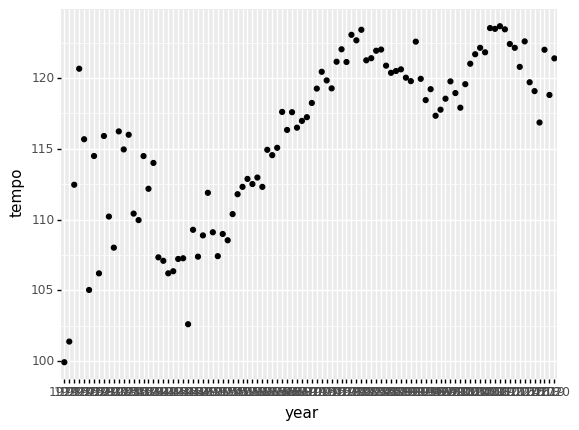

<ggplot: (183757330601)>

In [36]:
ggplot(data_agg_1, aes(x = "year", y = "tempo")) + geom_point()

## 2- Can we predict if a track is major or minor given it's other characteristics?

In [ ]:
data_2 = pd.read_csv("../Data/data.csv")
data_2.head()

## 3- Can we classify the songs into different "contexts" in which they would be played?

In [ ]:
data_3 = pd.read_csv("../Data/data.csv")
data_3.head()